In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from skimage.transform import resize
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model ,Sequential
from sklearn.model_selection import train_test_split




2024-09-10 00:22:55.785807: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-10 00:22:56.205945: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-10 00:22:56.920975: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
SIZE = 700

def prepare_dataset(img_directory, target_size=(SIZE, SIZE)):
    # Obtient la liste des noms de fichiers d'images dans le répertoire et les trie
    img_files = sorted(os.listdir(img_directory))

    # Initialise une liste pour stocker les images préparées
    X_train = []

    # Affiche un message indiquant le début de la préparation du jeu de données
    print(f"Préparation du jeu de données en niveaux de gris et redimensionnement pour {img_directory}...")

    # Parcours tous les fichiers d'images dans le répertoire
    for img_file in img_files:
        # Construit le chemin complet de l'image
        img_path = os.path.join(img_directory, img_file)

        # Lit l'image à l'aide de matplotlib
        img = plt.imread(img_path)

        # Vérifie si l'image est déjà en niveaux de gris
        if len(img.shape) == 3 and img.shape[2] == 3:
            # Convertit l'image en niveaux de gris à l'aide de la fonction rgb2gray
            gray_img = rgb2gray(img)
        else:
            gray_img = img

        # Redimensionne l'image à la taille spécifiée
        resized_img = resize(gray_img, target_size)

        # Ajoute l'image redimensionnée à la liste X_train
        X_train.append(resized_img)

    # Convertit la liste d'images en un tableau NumPy
    X_train = np.array(X_train)

    # Affiche un message indiquant la fin de la préparation du jeu de données et sa forme
    print("Terminé...")
    print(X_train.shape)

    # Renvoie le tableau NumPy contenant les images préparées
    return X_train

# Exemple d'utilisation de la fonction pour préparer des ensembles de données
img_directory1 = "/home/oumaima/Downloads/autoencoder_local_version/test/noisy_test"
X_test_noisy = prepare_dataset(img_directory1)

img_directory2 = "/home/oumaima/Downloads/autoencoder_local_version/test/good_test"
X_test_good_ = prepare_dataset(img_directory2)

img_directory3 = "/home/oumaima/Downloads/autoencoder_local_version/train/noisy_train"
X_train_noisy = prepare_dataset(img_directory3)

img_directory4 = "/home/oumaima/Downloads/autoencoder_local_version/train/good_train"
X_train_good_ = prepare_dataset(img_directory4)


Préparation du jeu de données en niveaux de gris et redimensionnement pour /home/oumaima/Downloads/autoencoder_local_version/test/noisy_test...
Terminé...
(22, 700, 700)
Préparation du jeu de données en niveaux de gris et redimensionnement pour /home/oumaima/Downloads/autoencoder_local_version/test/good_test...
Terminé...
(22, 700, 700)
Préparation du jeu de données en niveaux de gris et redimensionnement pour /home/oumaima/Downloads/autoencoder_local_version/train/noisy_train...
Terminé...
(220, 700, 700)
Préparation du jeu de données en niveaux de gris et redimensionnement pour /home/oumaima/Downloads/autoencoder_local_version/train/good_train...
Terminé...
(220, 700, 700)


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Paramètres
input_shape = (700, 700, 1)

# Définition de l'Autoencodeur
def build_autoencoder(input_shape):
    input_img = layers.Input(shape=input_shape)
    
    # Encodeur
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Décodeur
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)
    
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)
    
    # Couche Cropping2D pour ajuster la taille de la sortie à (700, 700)
    x = layers.Cropping2D(cropping=((2, 2), (2, 2)))(x)
    
    # Couche de sortie
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder = models.Model(input_img, decoded)
    
    return autoencoder

# Construction du modèle
autoencoder = build_autoencoder(input_shape)

# Définition de la fonction de perte personnalisée
def custom_reconstruction_loss(x_test, x_predict):
    lssim_loss = 1 - tf.image.ssim(x_test, x_predict, max_val=1.0)
    l2_loss = tf.reduce_sum(tf.square(x_test - x_predict))
    λ = 3
    reconstruction_loss = λ * lssim_loss + l2_loss
    return reconstruction_loss

# Compilation du modèle
autoencoder.compile(optimizer='adam', loss=custom_reconstruction_loss)

# Affichage du résumé du modèle
autoencoder.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 700, 700, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 700, 700, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 700, 700, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 350, 350, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 350, 350, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 350, 350, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 175, 175, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 175, 175, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 175, 175, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 88, 88, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 88, 88, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 88, 88, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_12 (UpSampling2D) │ (None, 176, 176, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 176, 176, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 176, 176, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_13 (UpSampling2D) │ (None, 352, 352, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 352, 352, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 352, 352, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_14 (UpSampling2D) │ (None, 704, 704, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d_2 (Cropping2D)       │ (None, 700, 700, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 700, 700, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 334,593 (1.28 MB)

 Trainable params: 333,697 (1.27 MB)

 Non-trainable params: 896 (3.50 KB)

In [14]:
# Entraînement de l'autoencodeur
history = autoencoder.fit(X_train_noisy, X_train_good_,
                          epochs=100,  # Nombre d'époques à ajuster selon vos besoins
                          batch_size=32,
                          validation_data=(X_test_noisy, X_test_good_))


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 82s 12s/step - loss: 913304.6875 - val_loss: 749132.5000
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 81s 12s/step - loss: 559937.8750 - val_loss: 528395.9375
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 81s 12s/step - loss: 400096.9375 - val_loss: 375122.9062
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 82s 12s/step - loss: 317807.1250 - val_loss: 332329.5312
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 82s 12s/step - loss: 264017.9375 - val_loss: 331553.6562
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 82s 12s/step - loss: 218509.5000 - val_loss: 341123.5625
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 81s 12s/step - loss: 182556.1406 - val_loss: 352673.0312
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 81s 12s/step - loss: 147987.3125 - val_loss: 381220.5625
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 81s 12s/step - loss: 136372.4844 - val_loss: 409202.7188
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 81s 12s/step - loss: 170798.6406 - val_loss: 408530.1562
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 81s 12s/step - loss: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step


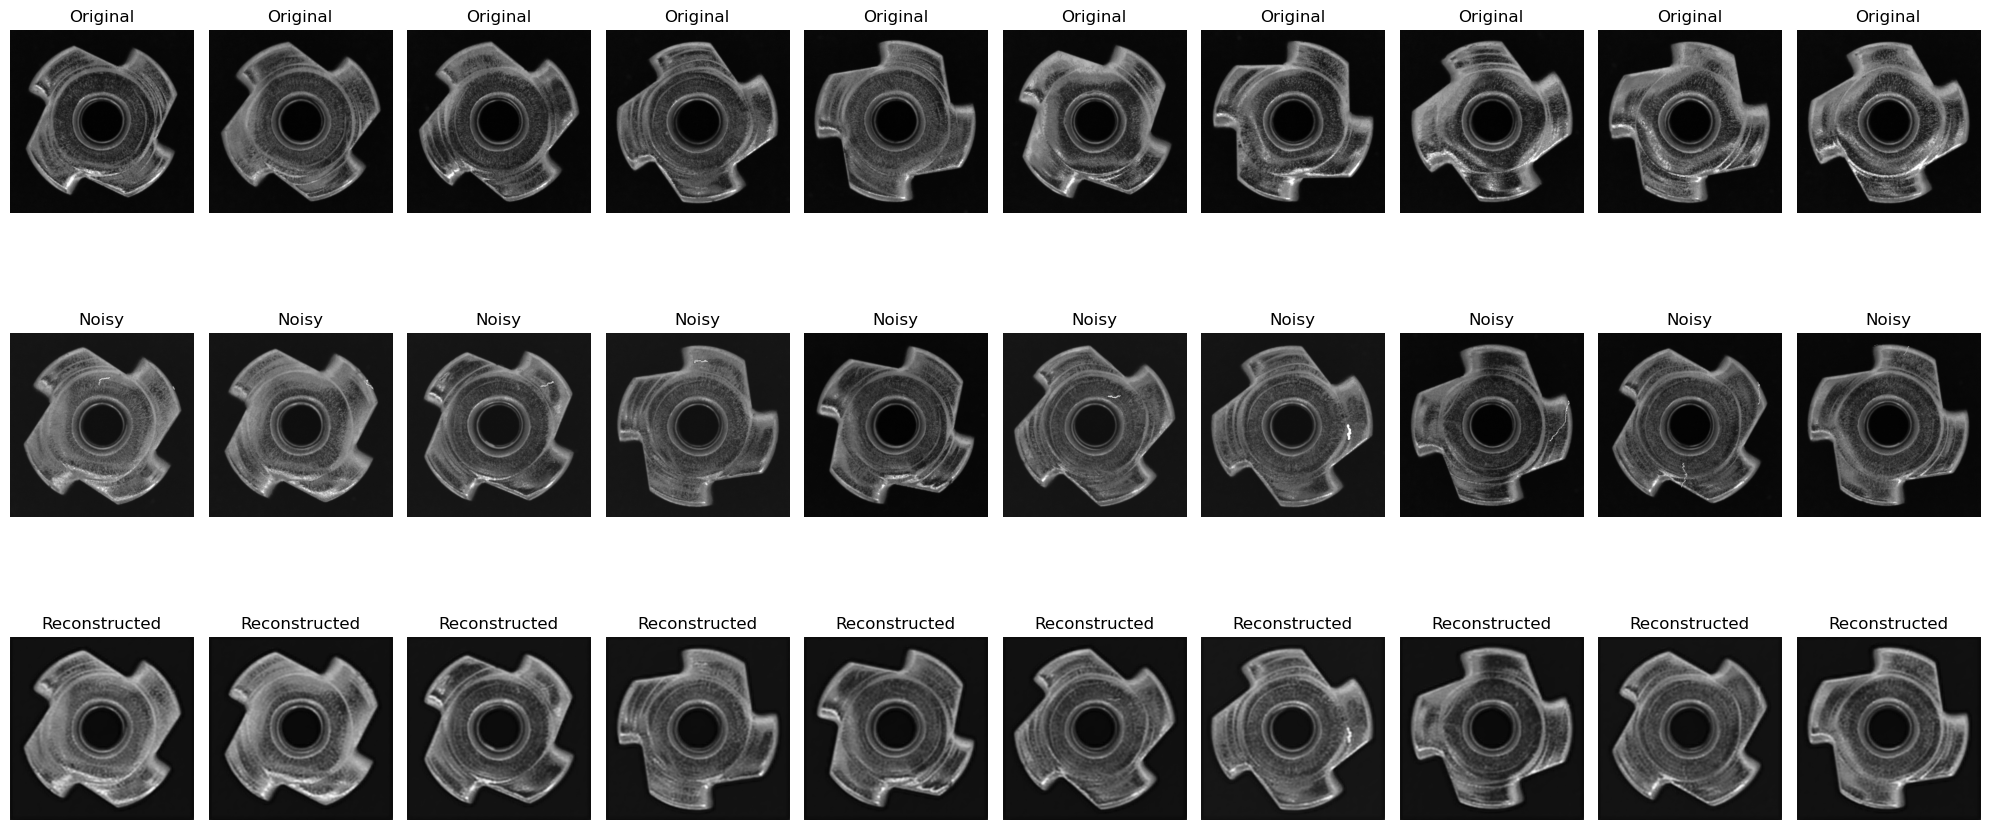

In [16]:
import matplotlib.pyplot as plt
import os

# Create a directory to save reconstructed images
output_dir = 'reconstructed_images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def display_and_save_results(original_images, noisy_images, reconstructed_images, num_images=10, save=True):
    plt.figure(figsize=(20, 10))
    
    for i in range(num_images):
        # Affichage de l'image originale
        plt.subplot(3, num_images, i + 1)
        plt.imshow(original_images[i].reshape(700, 700), cmap='gray')
        plt.title('Original')
        plt.axis('off')
        
        # Affichage de l'image avec du bruit
        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(noisy_images[i].reshape(700, 700), cmap='gray')
        plt.title('Noisy')
        plt.axis('off')
        
        # Affichage de l'image reconstruite
        plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(reconstructed_images[i].reshape(700, 700), cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')

        # Save the reconstructed images
        if save:
            reconstructed_img_path = os.path.join(output_dir, f'reconstructed_{i}.png')
            plt.imsave(reconstructed_img_path, reconstructed_images[i].reshape(700, 700), cmap='gray')
    
    # Display all results
    plt.tight_layout()
    plt.show()

# Sélectionner plus d'images de test
num_images = 10  # Afficher et sauvegarder 10 images

# Predictions with the autoencoder
reconstructed_images = autoencoder.predict(X_test_noisy[:num_images])

# Afficher et sauvegarder les résultats
display_and_save_results(X_test_good_[:num_images], X_test_noisy[:num_images], reconstructed_images, num_images=num_images)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


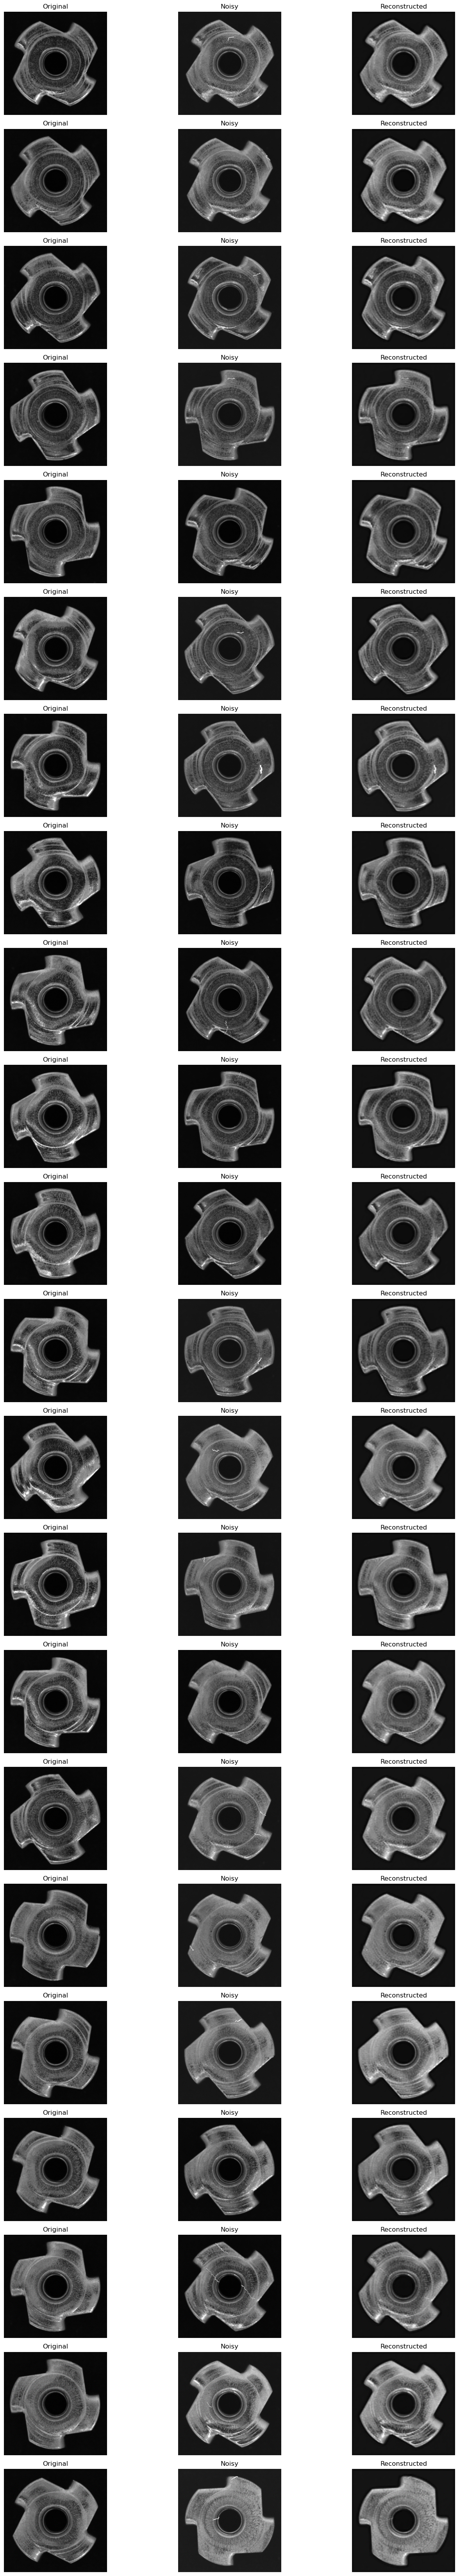

In [18]:
import matplotlib.pyplot as plt
import os

# Create a directory to save reconstructed images
output_dir = 'reconstructed_images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def display_and_save_results(original_images, noisy_images, reconstructed_images, num_images=10, save=True):
    # Set larger figure size for bigger images
    plt.figure(figsize=(15, num_images * 3))  # Increase figure size for bigger images
    
    for i in range(num_images):
        # Affichage de l'image originale (1ère colonne)
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(original_images[i].reshape(700, 700), cmap='gray')
        plt.title('Original')
        plt.axis('off')
        
        # Affichage de l'image avec du bruit (2ème colonne)
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(noisy_images[i].reshape(700, 700), cmap='gray')
        plt.title('Noisy')
        plt.axis('off')
        
        # Affichage de l'image reconstruite (3ème colonne)
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(reconstructed_images[i].reshape(700, 700), cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')

        # Save the reconstructed images
        if save:
            reconstructed_img_path = os.path.join(output_dir, f'reconstructed_{i}.png')
            plt.imsave(reconstructed_img_path, reconstructed_images[i].reshape(700, 700), cmap='gray')
    
    # Display all results
    plt.tight_layout()
    plt.show()

# Sélectionner plus d'images de test
num_images = 22  # Afficher et sauvegarder 10 images

# Predictions with the autoencoder
reconstructed_images = autoencoder.predict(X_test_noisy[:num_images])

# Afficher et sauvegarder les résultats
display_and_save_results(X_test_good_[:num_images], X_test_noisy[:num_images], reconstructed_images, num_images=num_images)
